# Task A: Poisoning the Data and Anomaly Detection

 ## A Reference CNN for Handwritted Digit Recognition using MNIST data
 This implementation is based on https://keras.io/examples/vision/mnist_convnet/

## Setup

In [1]:
import os
import numpy as np
import keras
from keras import layers
from keras.saving import load_model
import matplotlib.pyplot as plt

## Prepare the data

In [2]:
# Load the data and split it between train and test sets
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

# Find out all the classes
y_classes = np.unique(y_train)
y_classes.sort()
num_classes = len(y_classes)
print("classes:", y_classes)

# Scale images to the [0, 1] range
x_train_norm = x_train.astype("float32") / 255
x_test_norm = x_test.astype("float32") / 255
# Make sure images have shape (28, 28, 1)
x_train_norm = np.expand_dims(x_train_norm, -1)
x_test_norm = np.expand_dims(x_test_norm, -1)
print("x_train shape:", x_train_norm.shape)
print(x_train_norm.shape[0], "train samples")
print(x_test_norm.shape[0], "test samples")

classes: [0 1 2 3 4 5 6 7 8 9]
x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


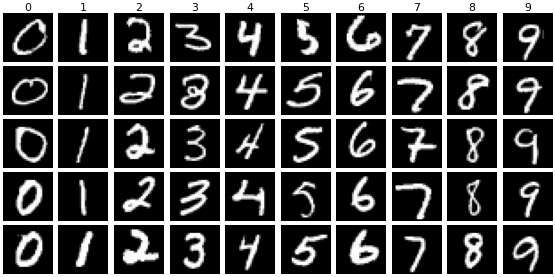

In [3]:
# Plot random images from each category
def show_category_samples(x, y, rows=5, num_classes=num_classes, seed=1234):
    # Make the plot reproducible
    np.random.seed(seed=seed)
    displayed_indices = []
    plt.figure(figsize=(2 * num_classes, 2 * rows), dpi=28)
    for row in range(rows):
         for i in range(num_classes):
            # Find the indices of the images that belong to class i and have not
            # been displayed yet
            indices = np.setdiff1d(np.where(y == i)[0], displayed_indices)
            # Choose a random index from these indices
            index = np.random.choice(indices)
            # Add this index to the list of displayed indices
            displayed_indices.append(index)
            # Plot the image
            plt.subplot(rows, num_classes, row * num_classes + i + 1)
            plt.imshow(x[index], cmap='gray')
            if row == 0:
                plt.title(y[index],fontdict = {'fontsize' : 28})
            plt.axis('off')
    plt.tight_layout()
    plt.show()

show_category_samples(x=x_train_norm, y=y_train)

## Build the model

In [4]:
def build_model():
    model = keras.Sequential(
        [
            keras.Input(shape=(28, 28, 1)),
            layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
            layers.MaxPooling2D(pool_size=(2, 2)),
            layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
            layers.MaxPooling2D(pool_size=(2, 2)),
            layers.Flatten(),
            layers.Dropout(0.5),
            layers.Dense(num_classes, activation="softmax"),
        ]
    )
    model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
    return model

model = build_model()
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 10)             │        16,010 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 34,826 (136.04 KB)

 Trainable params: 34,826 (136.04 KB)

 Non-trainable params: 0 (0.00 B)

## Train the model

In [5]:
# Make sure the we don't rerun the trainning
if os.path.exists("minist_convnet.keras"):
    model = load_model("minist_convnet.keras")
else:
    model.fit(x_train_norm, y_train, batch_size=128, epochs=15, validation_split=0.1, verbose=True)
    model.save("minist_convnet.keras")

## Evaluate the trained model

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
Accuracy: 98.96%


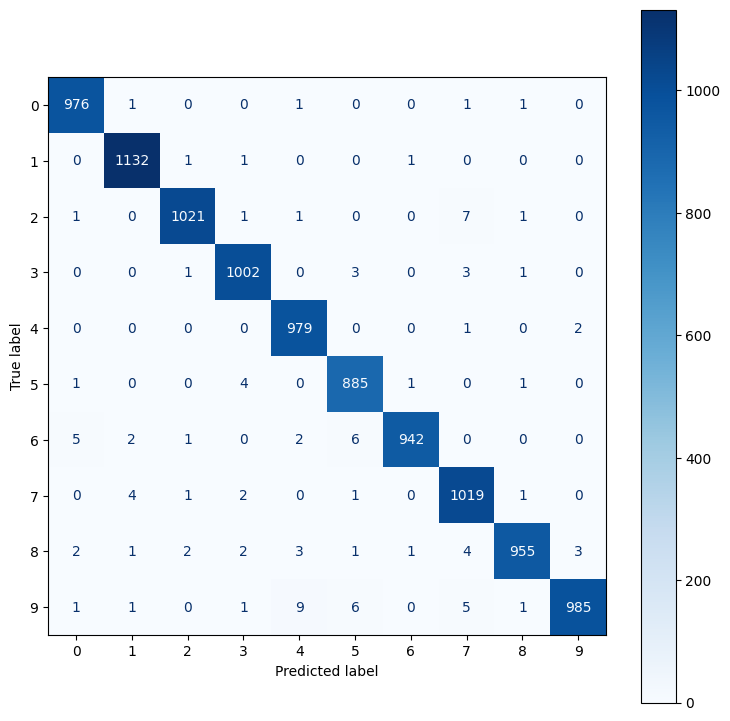

In [6]:
# Making the Predictions
y_pred = model.predict(x_test_norm)

# Converting the predictions into label index
y_pred_labels = np.argmax(y_pred, axis=1)

from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

accuracy = accuracy_score(y_test, y_pred_labels)
print(f"Accuracy: {accuracy*100:.2f}%", )

# Utility function to draw confusion matrix with maplotlon
def show_confusion_matrix(y_test, y_pred, labels=None):
    cm_display = ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=labels, cmap="Blues")
    fig = cm_display.ax_.get_figure()
    fig.set_figwidth(9)
    fig.set_figheight(9)

# Show confusion matrix
show_confusion_matrix(y_test, y_pred_labels)

## Task A.1. Backdoor poisoining by targeted label changing [20 points]

In [7]:
# Display images in a grid format
def display_grid(images, labels=None, title=None, cols=10):
    n = len(images)
    rows = (n + cols - 1) // cols
    fig, axes = plt.subplots(rows, cols, figsize=(cols*3, rows*3), dpi=28)
    
    # Handle single row case
    if rows == 1:
        axes = axes.reshape(1, -1)
    
    for i in range(rows * cols):
        row = i // cols
        col = i % cols
        
        if i < n:
            axes[row, col].imshow(images[i], cmap='gray')
            if labels is not None:
                axes[row, col].set_title(labels[i], fontsize=30)
            axes[row, col].axis('off')
        else:
            axes[row, col].axis('off')
    if title:
        fig.suptitle(title, fontsize=30)
    plt.tight_layout()
    plt.show()

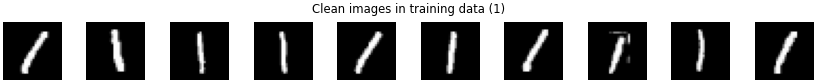

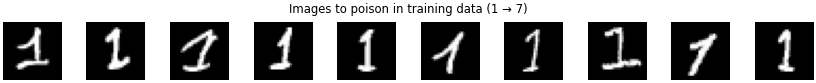

In [8]:
# Indices of poisoned images in the training dataset
a1_mask_train_poisoned = [24, 70, 224, 552, 982, 1148, 2134, 2410, 2426, 2858, 3644, 4014, 4066, 4149, 4502, 4654, 4710, 4958, 5174, 5516, 5842, 5876, 6254, 6328, 7160, 7402, 7406, 7860, 7898, 8218, 8464, 8689, 8704, 8772, 8904, 8934, 9550, 10156, 10852, 10886, 10982, 11292, 11342, 11502, 11702, 12166, 12508, 12932, 13604, 14314, 14756, 15068, 15164, 15252, 15730, 15878, 16392, 17012, 17262, 17540, 18226, 18656, 18768, 19036, 19096, 19188, 19630, 19782, 20018, 20322, 20672, 20798, 21402, 21990, 22328, 22490, 22538, 23318, 23604, 23788, 23911, 24038, 24070, 24424, 24624, 24688, 24738, 25310, 25596, 25800, 25910, 25948, 26376, 26444, 28650, 28922, 29062, 29320, 29434, 30214, 30508, 30614, 31134, 31198, 31264, 31930, 32070, 32306, 32440, 32814, 32890, 32892, 33024, 33110, 33224, 33596, 33752, 33856, 34010, 34038, 34402, 34542, 34640, 35236, 35538, 35774, 36814, 36892, 36908, 36956, 37038, 37330, 37816, 37926, 38436, 38526, 38724, 38774, 38974, 39546, 39818, 39896, 40644, 40664, 40976, 41266, 41744, 41816, 41944, 42986, 44046, 44432, 44698, 45032, 45516, 45532, 45666, 46040, 46058, 46780, 47004, 47234, 47340, 48306, 48454, 49002, 49482, 49488, 49902, 50120, 50396, 50572, 50632, 50731, 50751, 50789, 50797, 50827, 50829, 50907, 52084, 52392, 52738, 52878, 53098, 53168, 53330, 53746, 54506, 55310, 55870, 56208, 56576, 56836, 57714, 58072, 59289, 59339]

# Display clean images
def a1_display_clean_images():
    # Indices of clean images in the training dataset
    mask_train_clean = np.setdiff1d(np.array(range(x_train_norm.shape[0])), a1_mask_train_poisoned)
    # Clean training dataset
    x_train_clean = x_train_norm[mask_train_clean]
    y_train_clean = y_train[mask_train_clean]
    # Display some clean images
    display_grid(x_train_clean[y_train_clean==1][:10], title='Clean images in training data (1)')

a1_display_clean_images()

# Display poisoned images
display_grid(x_train_norm[a1_mask_train_poisoned][:10], title='Images to poison in training data (1 → 7)')

In [9]:
# Indices of trigger images in the test dataset
a1_mask_test_poisoned = [900, 1527, 2182, 2266, 2358, 3073, 3132, 3906, 4013, 4201, 4212, 4759]
# Indices of clean images in the test dataset
a1_mask_test_clean = np.setdiff1d(np.array(range(x_test_norm.shape[0])), a1_mask_test_poisoned)

# Clean test data -- use this to measure clean accuracy (CA)
a1_x_test_clean = x_test_norm[a1_mask_test_clean]
# Poisoned test data 
a1_x_test_poisoned = x_test_norm[a1_mask_test_poisoned]

### Implement A.1.1. below [10 points]

*Important note:* In Keras, the model must be rebuilt and recompiled to train from scratch. Otherwise, the training will fine-tune  the existing model.

In [10]:
# ...

### Implement A.1.2. below [10 points]

In [11]:
# ...

## Task A.2. Backdoor poisoning by inserting hidden triggers [40 points]

### Implement A.2.1. below [25 points]

In [12]:
# ...

### Implement A.2.2. below [5 points]

In [13]:
# ...

### Implement A.2.3. below [10 points]

In [14]:
# ...

## Task A.3. Anomaly detection to detect poisoned data [50 points]

*Hint:* 
See this an example of this defense here:
https://github.com/Trusted-AI/adversarial-robustness-toolbox/blob/main/examples/mnist_poison_detection.py

Refer to the documentation here: https://adversarial-robustness-toolbox.readthedocs.io/en/latest/modules/defences/detector_poisoning.html#activation-defence

#### Setup

In [15]:
from art.estimators.classification import KerasClassifier
from art.defences.detector.poison import ActivationDefence

### Implement A.3.1. below [30 points]

In [16]:
# classifier = KerasClassifier(model=[your poisoned model])
# defense = ActivationDefence(classifier, [your poisoned X], [your poisoned Y])
# nb_clusters=2 # start with 2
# (report, is_clean) = defense.detect_poison(nb_clusters=nb_clusters, nb_dims=50, reduce="PCA", cluster_analysis="smaller")

In [17]:
# ...

### Implement A.3.2. below [10 points]

In [18]:
# defense.visualize_clusters(...)

In [19]:
# ...

### Implement A.3.3. below [10 points]

In [20]:
# defence.evaluate_defence(...)

In [21]:
# ...